In [58]:
import math
import geopy
from sgp4.api import Satrec
import datetime
from pyproj import Transformer

In [18]:
# Calculate the Satellite's FoV: Implement a function to calculate the FoV based on the satellite's altitude, latitude, and longitude. This involves geometric calculations to map the satellite's position to a surface area on Earth.
# Filter CERES Data Based on FoV: Modify your plotting functions to only plot the data that falls within the satellite's FoV. This will likely involve filtering the latitude and longitude arrays based on the calculated FoV.
# Time-Dependent Processing: Implement a system that updates the satellite's position and FoV at regular intervals (e.g., every 5 minutes), and then plots the corresponding visible CERES data.

In [19]:

def calculate_satellite_fov(latitude, longitude, altitude):
    # Constants
    earth_radius_km = 6371  # Average radius of the Earth in kilometers

    # Convert altitude to radius from the Earth's center
    satellite_radius_km = earth_radius_km + altitude

    # Calculate the maximum horizon distance
    horizon_distance_km = math.sqrt(satellite_radius_km**2 - earth_radius_km**2)

    # Approximate the FoV in degrees (latitude and longitude)
    # This is a simplification and works best for lower altitudes
    max_lat_long_range = math.degrees(horizon_distance_km / earth_radius_km)

    # Calculate the boundary coordinates
    min_latitude = max(-90, latitude - max_lat_long_range)
    max_latitude = min(90, latitude + max_lat_long_range)
    min_longitude = max(-180, longitude - max_lat_long_range)
    max_longitude = min(180, longitude + max_lat_long_range)

    return min_latitude, max_latitude, min_longitude, max_longitude

# Example usage with dummy coordinates
dummy_latitude = 0    # degrees
dummy_longitude = 0   # degrees
dummy_altitude = 15000  # kilometers

fov_boundaries = calculate_satellite_fov(dummy_latitude, dummy_longitude, dummy_altitude)
fov_boundaries

(-90, 90, -180, 180)

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def plot_fov_radiation(variable_name, time_index, radiation_data, lat, lon, min_lat, max_lat, min_lon, max_lon, output_folder):
    # Filter the latitude and longitude arrays based on the FoV boundaries
    lat_filter = (lat >= min_lat) & (lat <= max_lat)
    lon_filter = (lon >= min_lon) & (lon <= max_lon)

    # Apply the filter to the radiation data
    radiation_data_fov = radiation_data[time_index, lat_filter, :][:, lon_filter]
    lat_fov = lat[lat_filter]
    lon_fov = lon[lon_filter]

    # Meshgrid for the filtered latitude and longitude
    lon2d, lat2d = np.meshgrid(lon_fov, lat_fov)

    # Plotting
    fig = plt.figure(figsize=(10, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

    # Similar color scale limits and colormap as in your original function
    vmin, vmax = (-450, 450) if "net" in variable_name else (0, 450)
    cmap = 'seismic' if "net" in variable_name else 'magma'
    radiation_plot = ax.pcolormesh(lon2d, lat2d, radiation_data_fov, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())

    cbar = plt.colorbar(radiation_plot, orientation='vertical', shrink=0.7)
    cbar.set_label('Radiation (W/m^2)')

    ax.gridlines(draw_labels=True)
    plt.title(f'{variable_name} {time_index//12 + 2000}-{time_index%12 + 1:02d}')

    # Save the figure
    plt.show()
    # os.makedirs(output_folder, exist_ok=True)
    # plt.savefig(os.path.join(output_folder, f'{variable_name}_FoV_{time_index//12 + 2000}_{time_index%12 + 1:02d}.png'), dpi=300)
    # plt.close(fig)

In [21]:
# Example satellite position
satellite_latitude = 10  # degrees
satellite_longitude = 20 # degrees
satellite_altitude = 400 # kilometers

# Calculate FoV
min_lat, max_lat, min_lon, max_lon = calculate_satellite_fov(satellite_latitude, satellite_longitude, satellite_altitude)

/var/folders/nh/9y501_nj2x56h2t3ch9_05f40000gn/T/ipykernel_54227/2326570468.py:25: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  radiation_data = data.variables['toa_sw_all_mon'][:]
/var/folders/nh/9y501_nj2x56h2t3ch9_05f40000gn/T/ipykernel_54227/2326570468.py:25: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  radiation_data = data.variables['toa_sw_all_mon'][:]


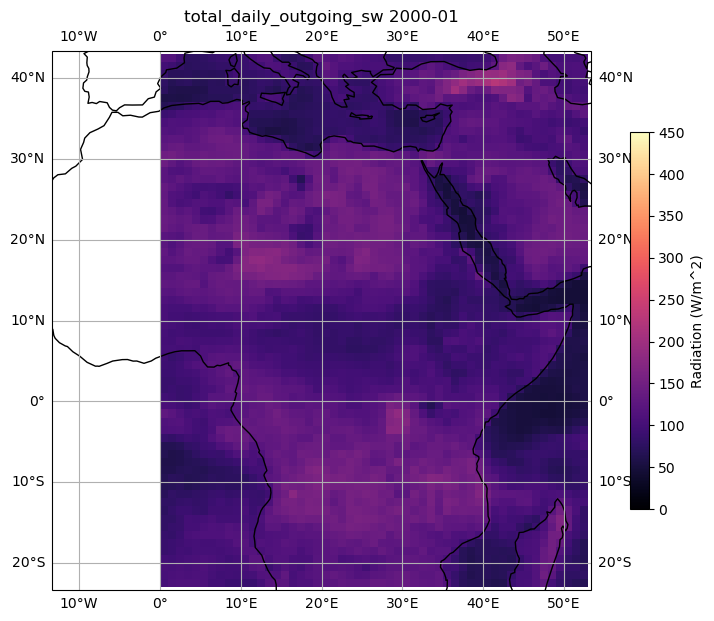

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def plot_fov_radiation(variable_name, time_index, radiation_data, lat, lon, min_lat, max_lat, min_lon, max_lon, output_folder):
    # Filter the latitude and longitude arrays based on the FoV boundaries
    lat_filter = (lat >= min_lat) & (lat <= max_lat)
    lon_filter = (lon >= min_lon) & (lon <= max_lon)

    # Apply the filter to the radiation data
    radiation_data_fov = radiation_data[time_index, lat_filter, :][:, lon_filter]
    lat_fov = lat[lat_filter]
    lon_fov = lon[lon_filter]

    # Meshgrid for the filtered latitude and longitude
    lon2d, lat2d = np.meshgrid(lon_fov, lat_fov)

    # Plotting
    fig = plt.figure(figsize=(10, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

    # Similar color scale limits and colormap as in your original function
    vmin, vmax = (-450, 450) if "net" in variable_name else (0, 450)
    cmap = 'seismic' if "net" in variable_name else 'magma'
    radiation_plot = ax.pcolormesh(lon2d, lat2d, radiation_data_fov, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())

    cbar = plt.colorbar(radiation_plot, orientation='vertical', shrink=0.7)
    cbar.set_label('Radiation (W/m^2)')

    ax.gridlines(draw_labels=True)
    plt.title(f'{variable_name} {time_index//12 + 2000}-{time_index%12 + 1:02d}')

    # Save the figure
    plt.show()
    # os.makedirs(output_folder, exist_ok=True)
    # plt.savefig(os.path.join(output_folder, f'{variable_name}_FoV_{time_index//12 + 2000}_{time_index%12 + 1:02d}.png'), dpi=300)
    # plt.close(fig)

def calculate_satellite_fov(latitude, longitude, altitude):
    # Constants
    earth_radius_km = 6371  # Average radius of the Earth in kilometers

    # Convert altitude to radius from the Earth's center
    satellite_radius_km = earth_radius_km + altitude

    # Calculate the maximum horizon distance
    horizon_distance_km = math.sqrt(satellite_radius_km**2 - earth_radius_km**2)

    # Approximate the FoV in degrees (latitude and longitude)
    # This is a simplification and works best for lower altitudes
    max_lat_long_range = math.degrees(horizon_distance_km / earth_radius_km)

    # Calculate the boundary coordinates
    min_latitude = max(-90, latitude - max_lat_long_range)
    max_latitude = min(90, latitude + max_lat_long_range)
    min_longitude = max(-180, longitude - max_lat_long_range)
    max_longitude = min(180, longitude + max_lat_long_range)

    return min_latitude, max_latitude, min_longitude, max_longitude

# Example satellite position
satellite_latitude = 10  # degrees
satellite_longitude = 20 # degrees
satellite_altitude = 1000 # kilometers

# Calculate FoV
min_lat, max_lat, min_lon, max_lon = calculate_satellite_fov(satellite_latitude, satellite_longitude, satellite_altitude)

# Define the variable name and time index for the plot (as per your data)
variable_name = "total_daily_outgoing_sw" # example variable name
time_index = 0 # example time index

# Define the output folder for the plots
output_folder = "path/to/output/folder"


# Replace this with the actual path to your CERES dataset file
dataset_path = 'data/CERES_EBAF-TOA_Ed4.2_Subset_200003-202308.nc'
import netCDF4 as nc
# Load the dataset
data = nc.Dataset(dataset_path)

# Extract the radiation data, latitude, and longitude from the dataset
# Replace 'radiation_variable_name' with the actual variable name from your dataset
radiation_data = data.variables['toa_sw_all_mon'][:]
lat = data.variables['lat'][:]
lon = data.variables['lon'][:]


# Plot the FoV radiation data
plot_fov_radiation(variable_name, time_index, radiation_data, lat, lon, min_lat, max_lat, min_lon, max_lon, output_folder)

In [48]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from geopy.distance import great_circle

def is_within_fov(sat_lat, sat_lon, horizon_dist, point_lat, point_lon):
    """
    Check if a point is within the satellite's field of view.
    """
    distance = great_circle((sat_lat, sat_lon), (point_lat, point_lon)).kilometers
    return distance <= horizon_dist

def plot_fov_radiation_scatter(variable_name, time_index, radiation_data, lat, lon, sat_lat, sat_lon, horizon_dist, output_path):
    # Initialize an empty list to hold the radiation values within the FoV
    lat_points, lon_points, radiation_points = [], [], []

    # Iterate over the grid and collect data points within the FoV
    for i in range(len(lat)):
        for j in range(len(lon)):
            if is_within_fov(sat_lat, sat_lon, horizon_dist, lat[i], lon[j]):
                lat_points.append(lat[i])
                lon_points.append(lon[j])
                radiation_points.append(radiation_data[time_index, i, j])

    # Plotting
    fig = plt.figure(figsize=(10, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()

    vmin, vmax = (-450, 450) if "net" in variable_name else (0, 450)
    cmap = 'seismic' if "net" in variable_name else 'magma'
    scatter_plot = ax.scatter(lon_points, lat_points, c=radiation_points, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())

    cbar = plt.colorbar(scatter_plot, orientation='vertical', shrink=0.7)
    cbar.set_label('Radiation (W/m^2)')

    ax.gridlines(draw_labels=True)
    plt.title(f'{variable_name} {time_index//12 + 2000}-{time_index%12 + 1:02d}')
    plt.savefig(output_path)
    plt.close(fig)
    plt.show()

def calculate_satellite_fov(latitude, longitude, altitude):
    # Constants
    earth_radius_km = 6371  # Average radius of the Earth in kilometers

    # Convert altitude to radius from the Earth's center
    satellite_radius_km = earth_radius_km + altitude

    # Calculate the maximum horizon distance
    horizon_distance_km = math.sqrt(satellite_radius_km**2 - earth_radius_km**2)

    return horizon_distance_km

# Example satellite position
satellite_latitude = 10  # degrees
satellite_longitude = 20 # degrees
satellite_altitude = 1200 # kilometers

# Calculate horizon distance for FoV
horizon_distance_km = calculate_satellite_fov(satellite_latitude, satellite_longitude, satellite_altitude)

# Load the dataset
import netCDF4 as nc
data = nc.Dataset('data/CERES_EBAF-TOA_Ed4.2_Subset_200003-202308.nc')

# Extract the radiation data, latitude, and longitude from the dataset
radiation_data = data.variables['toa_sw_all_mon'][:]
lat = data.variables['lat'][:]
lon = data.variables['lon'][:]

# Define the variable name and time index for the plot
variable_name = "total_daily_outgoing_sw" # example variable name
time_index = 0 # example time index

# Define the output folder for the plots
output_folder = "FOV_sliced_data"

# Plot the FoV radiation data
plot_fov_radiation_scatter(variable_name, time_index, radiation_data, lat, lon, satellite_latitude, satellite_longitude, horizon_distance_km, output_folder)

/var/folders/nh/9y501_nj2x56h2t3ch9_05f40000gn/T/ipykernel_54227/3389531173.py:70: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  radiation_data = data.variables['toa_sw_all_mon'][:]
/var/folders/nh/9y501_nj2x56h2t3ch9_05f40000gn/T/ipykernel_54227/3389531173.py:70: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  radiation_data = data.variables['toa_sw_all_mon'][:]


In [53]:
import os

altitudes = [1000, 1000, 1000, 1000, 1000]
lats = [0, 5, 10, 15, 20]
lons = [0, 0, 0, 0, 0]

output_folder = "FOV_sliced_data"
os.makedirs(output_folder, exist_ok=True)

# Ensure that 'lat' and 'lon' are arrays representing the latitude and longitude grid of the CERES data
# Example:
# lat = data.variables['lat'][:]
# lon = data.variables['lon'][:]

for idx, (alt, sat_lat, sat_lon) in enumerate(zip(altitudes, lats, lons)):
    horizon_distance_km = calculate_satellite_fov(sat_lat, sat_lon, alt)
    plot_filename = os.path.join(output_folder, f'fov_frame_{idx}.png')
    plot_fov_radiation_scatter("total_daily_outgoing_sw", 0, radiation_data, lat, lon, sat_lat, sat_lon, horizon_distance_km, plot_filename)


In [54]:
import imageio

filenames = [os.path.join(output_folder, f'fov_frame_{idx}.png') for idx in range(len(altitudes))]
images = [imageio.imread(filename) for filename in filenames]

animation_path = os.path.join(output_folder, 'satellite_fov_animation.gif')
imageio.mimsave(animation_path, images, duration=0.5)  # duration controls frame rate


/var/folders/nh/9y501_nj2x56h2t3ch9_05f40000gn/T/ipykernel_54227/3233876472.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(filename) for filename in filenames]


In [59]:
def tle_convert(tle_dict: dict) -> dict:
    """
    Convert a TLE dictionary into the corresponding Keplerian elements.

    Parameters
    ----------
    tle_dict : dict
        Dictionary of TLE data.

    Returns
    -------
    dict
        Dictionary containing Keplerian elements.
    """
    # Standard gravitational parameter for the Earth
    GM = 398600.4415 * (1e3)**3 # m^3/s^2

    # Convert RAAN from degrees to radians
    RAAN = np.radians(float(tle_dict['right ascension of the ascending node']))
    
    # Convert argument of perigee from degrees to radians
    arg_p = np.radians(float(tle_dict['argument of perigee']))
    
    # Convert mean motion from revolutions per day to radians per second
    mean_motion = float(tle_dict['mean motion']) * (2 * np.pi / 86400)
    
    # Compute the period of the orbit in seconds
    period = 2 * np.pi / mean_motion
    
    # Compute the semi-major axis
    n = mean_motion # mean motion in radians per second
    a = (GM / (n ** 2)) ** (1/3) / 1000 # in km
    
    # Convert mean anomaly from degrees to radians
    M = np.radians(float(tle_dict['mean anomaly']))
    
    # Extract eccentricity as decimal value
    e = float("0." + tle_dict['eccentricity'])
    
    # Convert inclination from degrees to radians
    inclination = np.radians(float(tle_dict['inclination']))
    
    # Initial Guess at Eccentric Anomaly
    if M < np.pi:
        E = M + (e / 2)
    else:
        E = M - (e / 2)

    # Numerical iteration for Eccentric Anomaly
    f = lambda E: E - e * np.sin(E) - M
    fp = lambda E: 1 - e * np.cos(E)
    E = np.float64(E)
    r_tol = 1e-8 # set the convergence tolerance for the iteration
    max_iter = 50 # set the maximum number of iterations allowed
    for it in range(max_iter):
        f_value = f(E)
        fp_value = fp(E)
        E_new = E - f_value / fp_value
        if np.abs(E_new - E) < r_tol:
            E = E_new
            break
        E = E_new
    else:
        raise ValueError("Eccentric anomaly did not converge")
        
    eccentric_anomaly = E

    # Compute True Anomaly
    true_anomaly = 2 * np.arctan2(np.sqrt(1 + e) * np.sin(eccentric_anomaly / 2),
                                  np.sqrt(1 - e) * np.cos(eccentric_anomaly / 2))

    # Dictionary of Keplerian elements
    keplerian_dict = {'a': a, 'e': e, 'i': inclination, 'RAAN': RAAN, 'arg_p': arg_p, 'true_anomaly': np.degrees(true_anomaly)}
    return keplerian_dict

def TLE_time(TLE: str) -> float:
    """
    Find the time of a TLE in Julian Day format.

    Parameters
    ----------
    TLE : str
        The TLE string.

    Returns
    -------
    float
        Time in Julian Day format.
    """
    #find the epoch section of the TLE
    epoch = TLE[18:32]
    #convert the first two digits of the epoch to the year
    year = 2000+int(epoch[0:2])
    
    # the rest of the digits are the day of the year and fractional portion of the day
    day = float(epoch[2:])
    #convert the day of the year to a day, month, year format
    date = datetime.datetime(year, 1, 1) + datetime.timedelta(day - 1)
    #convert the date to a julian date
    jd = (date - datetime.datetime(1858, 11, 17)).total_seconds() / 86400.0 + 2400000.5
    return jd

def ecef_to_lla(x, y, z):
    """
    Convert Earth-Centered, Earth-Fixed (ECEF) coordinates to Latitude, Longitude, Altitude (LLA).

    Parameters
    ----------
    x : List[float]
        x coordinates in km.
    y : List[float]
        y coordinates in km.
    z : List[float]
        z coordinates in km.

    Returns
    -------
    tuple
        Latitudes in degrees, longitudes in degrees, and altitudes in km.
    """
    # Convert input coordinates to meters
    x_m, y_m, z_m = x * 1000, y * 1000, z * 1000
    
    # Create a transformer for converting between ECEF and LLA
    transformer = Transformer.from_crs(
        "EPSG:4978", # WGS-84 (ECEF)
        "EPSG:4326", # WGS-84 (LLA)
        always_xy=True # Specify to always return (X, Y, Z) ordering
    )

    # Convert coordinates
    lon, lat, alt_m = transformer.transform(x_m, y_m, z_m)

    # Convert altitude to kilometers
    alt_km = alt_m / 1000

    return lat, lon, alt_km


from astropy.time import Time
from astropy.coordinates import GCRS, ITRS, CartesianRepresentation, CartesianDifferential
from astropy import units as u

def eci2ecef_astropy(eci_pos, eci_vel, mjd):
    """
    Convert ECI (Earth-Centered Inertial) coordinates to ECEF (Earth-Centered, Earth-Fixed) coordinates using Astropy.

    Parameters
    ----------
    eci_pos : np.ndarray
        ECI position vectors.
    eci_vel : np.ndarray
        ECI velocity vectors.
    mjd : float
        Modified Julian Date.

    Returns
    -------
    tuple
        ECEF position vectors and ECEF velocity vectors.
    """
    # Convert MJD to isot format for Astropy
    time_utc = Time(mjd, format="mjd", scale='utc')

    # Convert ECI position and velocity to ECEF coordinates using Astropy
    eci_cartesian = CartesianRepresentation(eci_pos.T * u.km)
    eci_velocity = CartesianDifferential(eci_vel.T * u.km / u.s)
    gcrs_coords = GCRS(eci_cartesian.with_differentials(eci_velocity), obstime=time_utc)
    itrs_coords = gcrs_coords.transform_to(ITRS(obstime=time_utc))

    # Get ECEF position and velocity from Astropy coordinates
    ecef_pos = np.column_stack((itrs_coords.x.value, itrs_coords.y.value, itrs_coords.z.value))
    ecef_vel = np.column_stack((itrs_coords.v_x.value, itrs_coords.v_y.value, itrs_coords.v_z.value))

    return ecef_pos, ecef_vel

In [56]:
def sgp4_prop_TLE(TLE: str, jd_start: float, jd_end: float, dt: float, alt_series: bool = False):
    """
    Given a TLE, a start time, end time, and time step, propagate the TLE and return the time-series of Cartesian coordinates and accompanying time-stamps (MJD).
    
    This is simply a wrapper for the SGP4 routine in the sgp4.api package (Brandon Rhodes).

    Parameters
    ----------
    TLE : str
        TLE to be propagated.
    jd_start : float
        Start time of propagation in Julian Date format.
    jd_end : float
        End time of propagation in Julian Date format.
    dt : float
        Time step of propagation in seconds.
    alt_series : bool, optional
        If True, return the altitude series as well as the position series. Defaults to False.

    Returns
    -------
    list
        List of lists containing the time-series of Cartesian coordinates, and accompanying time-stamps (MJD).
    """
    if jd_start > jd_end:
        print('jd_start must be less than jd_end')
        return

    ephemeris = []
    
    #convert dt from seconds to julian day
    dt_jd = dt/86400

    #split at the new line
    split_tle = TLE.split('\n')
    s = split_tle[0]
    r = split_tle[1]

    fr = 0.0 # precise fraction (SGP4 docs for more info)
    
    #create a satellite object
    satellite = Satrec.twoline2rv(s, r)

    time = jd_start
    # for i in range (jd_start, jd_end, dt):
    while time < jd_end:
        # propagate the satellite to the next time step
        # Position is in idiosyncratic True Equator Mean Equinox coordinate frame used by SGP4
        # Velocity is the rate at which the position is changing, expressed in kilometers per second
        error, position, velocity = satellite.sgp4(time, fr)
        if error != 0:
            print('Satellite position could not be computed for the given date')
            break
        else:
            ephemeris.append([time,position, velocity]) #jd time, pos, vel
        time += dt_jd

    return ephemeris